In [37]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPModel, CLIPProcessor, AdamW, get_scheduler
from tqdm import tqdm

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# train dataset
data_dir = "/root/20242R0136COSE47402/FinalProject/data/train"
class_candidate = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
text_inputs = []
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        folder = folder.replace('_', ' ')
        text_inputs.append(f"a photo of {folder}")

In [39]:
image_paths = []
image_labels = []

for class_name in class_candidate:
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        if img_name[0] == '.':
            continue
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        class_name = class_name.replace('_', ' ')
        image_labels.append(f"a photo of {class_name}")

print(f"train dataset size : {len(image_paths)}")

train dataset size : 75750


In [40]:
def collate_fn(batch):
    inputs, labels = zip(*batch)

    input_ids = [inp['input_ids'] for inp in inputs]
    attention_masks = [inp['attention_mask'] for inp in inputs]
    pixel_values = [inp['pixel_values'] for inp in inputs]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    pixel_values = torch.stack(pixel_values)

    batch_inputs = {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'pixel_values': pixel_values
    }

    return batch_inputs, labels


In [41]:
def clip_loss(logits_per_image):
    targets = torch.arange(len(logits_per_image), device=logits_per_image.device)

    return (F.cross_entropy(logits_per_image, targets) + F.cross_entropy(logits_per_image.T, targets)) / 2


In [42]:
class Food101DataSet(Dataset):
    def __init__(self, image_paths, image_labels, processor):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.processor = processor
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.image_labels[idx]
        inputs = self.processor(text=label, images=image, return_tensors='pt')
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

train_dataset = Food101DataSet(image_paths, image_labels, processor)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [44]:
torch.cuda.empty_cache()

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 11.67 GiB of which 17.56 MiB is free. Process 1011094 has 5.89 GiB memory in use. Process 1011730 has 5.73 GiB memory in use. Of the allocated memory 5.39 GiB is allocated by PyTorch, and 374.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
epochs = 12
num_warmup_steps = int(0.1 * len(train_dataloader)) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=len(train_dataloader) * epochs)

In [ ]:
model.train()
losses = []

for epoch in range(epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} / {epochs}")
    for batch in progress_bar:
        batch_inputs, labels = batch 
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        outputs = model(**batch_inputs)

        logits_per_image = outputs.logits_per_image
        loss = clip_loss(logits_per_image)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=loss.item())
    print(f"epoch {epoch + 1} finished.")

print("Train completed.")

Epoch 1 / 12:   0%|          | 1/4735 [00:00<40:49,  1.93it/s, loss=0.641]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 11.67 GiB of which 19.56 MiB is free. Process 1011094 has 5.89 GiB memory in use. Process 1011730 has 5.73 GiB memory in use. Of the allocated memory 5.39 GiB is allocated by PyTorch, and 374.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
loss_store_path = "/root/20242R0136COSE47402/FinalProject/src/origin_clip_loss.txt"
with open (loss_store_path, 'w') as file:
    for loss in losses:
        file.write(f"{loss}\n")

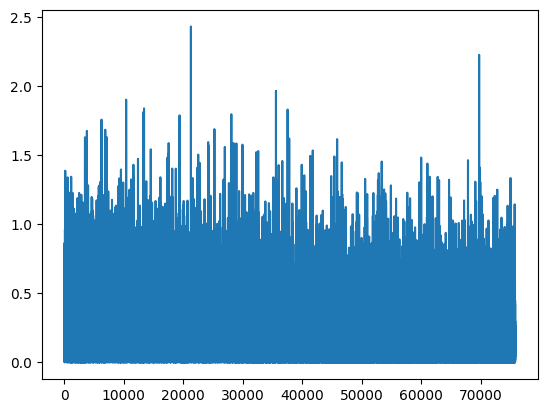

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# test dataset
data_dir = "/root/20242R0136COSE47402/FinalProject/data/test"
class_candidate = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
text_inputs = []
for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        folder = folder.replace('_', ' ')
        text_inputs.append(f"a photo of {folder}")

In [ ]:
image_paths = []
image_labels = []

for class_name in class_candidate:
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        if img_name[0] == '.':
            continue
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        class_name = class_name.replace('_', ' ')
        image_labels.append(f"a photo of {class_name}")

print(f"test dataset size : {len(image_paths)}")

test dataset size : 25250


In [ ]:
ans = 0
model.eval()

for idx, img_path in enumerate(image_paths):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(text=text_inputs, images=image, return_tensors='pt', padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()} 
    outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    if text_inputs[torch.argmax(probs).item()] == image_labels[idx]:
        ans += 1
    if idx % 2000 == 0:
        print(f"# {idx} finished.")
        
accuracy = ans / len(image_paths) * 100
accuracy

# 0 finished.


NameError: name 'result' is not defined